In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings
# from PIL import Image

In [143]:
# Предсказания на 5 недель
df_pred = pd.read_csv('../prediction_2023.05.27_horizont_5.csv')
# Реальные пожары
df_real = pd.read_csv('../DL_FIRE_J1V-C2_390990/fire_nrt_J1V-C2_390990.csv')
# Предсказания на 18 недель
df_pred_18 = pd.read_csv('../prediction_2023.05.27_horizont_18.csv')

In [144]:
def read_pred(df_orig: pd.DataFrame) -> pd.DataFrame:
    df = df_orig.copy()
    # Удалим из df столбцы с координатами, оставив только максимальные и минимальные значения широты и долготы для прямоугольников
    df['geom'] = df['geom'].str.strip('POLYGON ((').str.strip('))')
    df[['Point_1', 'Point_2', 'Point_3', 'Point_4', 'Point_5']]=df['geom'].str.split(',', expand= True)
    df[['lon_min', 'lat_min']] = df['Point_1'].str.split(' ', expand= True)
    df[['none', 'lon_max', 'lat_max']] = df['Point_3'].str.split(' ', expand= True)
    df.drop(['geom', 'Point_1', 'Point_2', 'Point_3', 'Point_4', 'Point_5', 'none'], axis= 1, inplace=True)
    df = df.astype({'lon_min': float, 'lat_min': float, 'lon_max': float, 'lat_max': float})
    return(df)

## Считываем предсказанные и реальные пожары на 5 недель вперед

In [145]:
df_pred = read_pred(df_pred)
print('Количество ячеек в предсказании:', len(df_pred))
df_pred.head()

Количество ячеек в предсказании: 69600


,longitude,latitude,fire_proba,lon_min,lat_min,lon_max,lat_max
0,19.9,54.5,0.021414,19.8,54.4,20.0,54.6
1,19.9,54.7,0.004216,19.8,54.6,20.0,54.8
2,20.1,54.3,0.001340,20.0,54.2,20.2,54.4
3,20.1,54.5,0.036835,20.0,54.4,20.2,54.6
4,20.1,54.7,0.004705,20.0,54.6,20.2,54.8


In [146]:
df_real_data = df_real.copy()
df_real_data[['year', 'month', 'day']] = df_real_data['acq_date'].str.split('-', expand=True).astype(int)
df_real_data.drop(['acq_date'], axis= 1, inplace= True)
df_real_data = df_real_data[
    (df_real_data['month'] == 5) & (df_real_data['day'] >= 27) |
    (df_real_data['month'] == 6) | 
    (df_real_data['month'] == 7) & (df_real_data['day'] <= 1)
].reset_index(drop=True)

print('Количество центров случившихся пожаров:', len(df_real_data))
df_real_data.head()

Количество центров случившихся пожаров: 72187


,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,year,month,day
0,52.55636,39.57774,322.87,0.53,0.42,1,1,VIIRS,n,2.0NRT,287.27,7.55,N,2023,5,27
1,51.13934,37.93134,332.26,0.50,0.41,1,1,VIIRS,n,2.0NRT,285.54,3.38,N,2023,5,27
2,51.12098,37.99788,298.34,0.50,0.41,1,1,VIIRS,n,2.0NRT,283.82,0.49,N,2023,5,27
3,50.61432,36.60144,301.58,0.47,0.39,1,1,VIIRS,n,2.0NRT,285.02,0.94,N,2023,5,27
4,50.61169,36.55828,304.90,0.47,0.39,1,1,VIIRS,n,2.0NRT,285.98,0.85,N,2023,5,27


## Сравниваем предсказания и реальные пожары на 5 недель

In [207]:
# разкомментировать, если надо пересчитать заново
# res = {}
# for i, row in df_real_data.iterrows():
#     a = df_pred[(df_pred.lon_min <= row['longitude']) & (df_pred.lon_max >= row['longitude']) &
#     (df_pred.lat_min <= row['latitude']) & (df_pred.lat_max >= row['latitude'])].values.tolist()
#     if len(a) > 0:
#         a = a[0]
#         a.append(row['longitude'])
#         a.append(row['latitude'])
#         a.append(row['brightness'])
#         res[i] = a
    
# res_df = pd.DataFrame.from_dict(res, orient='index', 
#                 columns=['longitude', 'latitude', 'fire_proba', 'lon_min', 'lat_min', 'lon_max','lat_max', 'real_longitude', 'real_latitude', 'brightness'])
# res_df.to_csv(f'../res/NEW_result1_brightness.csv', index = False)

res_df = pd.read_csv('../res/NEW_result1_brightness.csv')
print(len(res_df))
res_df.head()

71156


,longitude,latitude,fire_proba,lon_min,lat_min,lon_max,lat_max,real_longitude,real_latitude,brightness
0,39.5,52.5,0.056703,39.4,52.4,39.6,52.6,39.57774,52.55636,322.87
1,37.9,51.1,0.097052,37.8,51.0,38.0,51.2,37.93134,51.13934,332.26
2,37.9,51.1,0.097052,37.8,51.0,38.0,51.2,37.99788,51.12098,298.34
3,36.7,50.7,0.236118,36.6,50.6,36.8,50.8,36.60144,50.61432,301.58
4,36.5,50.7,0.030971,36.4,50.6,36.6,50.8,36.55828,50.61169,304.90


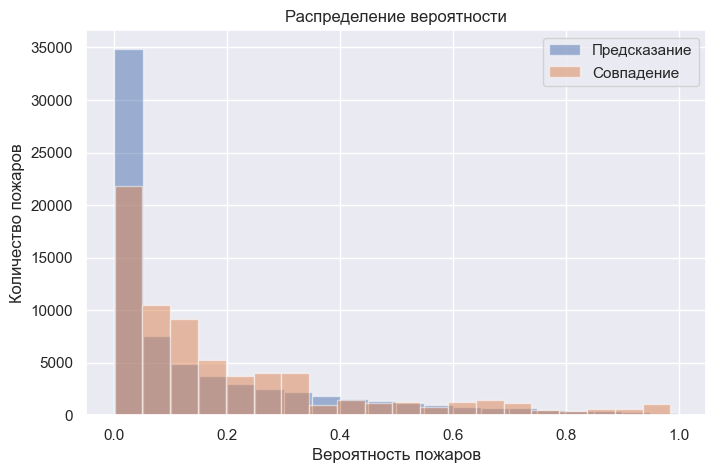

In [206]:
plt.figure(figsize=(8,5))
df_pred['fire_proba'].plot(
    kind='hist',
    title='Распределение вероятности',
    alpha=0.5,
    label='Предсказание',
    bins=20
)
res_df['fire_proba'].plot(
    kind='hist',
    alpha=0.5,
    label='Совпадение',
    bins = 20
)
plt.xlabel('Вероятность пожаров')
plt.ylabel('Количество пожаров')
plt.legend()
plt.show()

In [149]:
# удаляем дубликаты из пересечений, тк в одном квадрате мб несколько очагов
res_df_no_dup = res_df.copy()
res_df_no_dup = res_df_no_dup.drop_duplicates(subset=['latitude', 'longitude'])
print('Количество совпадений:', len(res_df))
print('Количество совпадений без дубликатов:', len(res_df_no_dup))

Количество совпадений: 71156
Количество совпадений без дубликатов: 3428


In [150]:
heatmap_data = df_pred.pivot(index='lat_min', columns='lon_min', values='fire_proba')
heatmap_data.index = heatmap_data.index.astype(int)
heatmap_data.columns = [round(col, 1) for col in heatmap_data.columns]

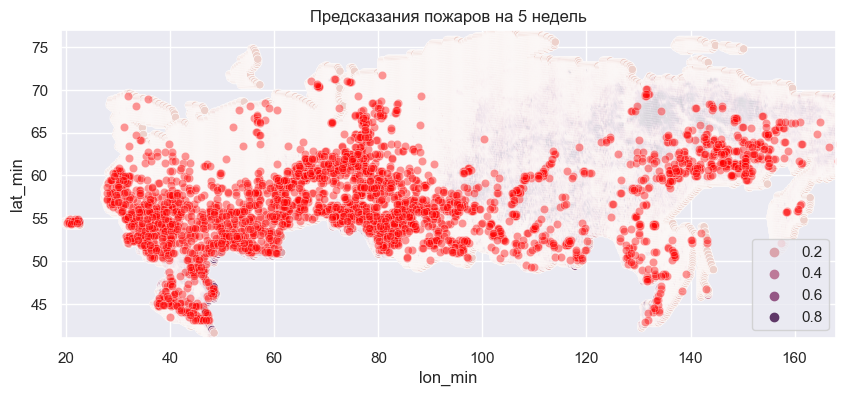

In [157]:
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=[10, 4])

sns.scatterplot(
    data=df_pred, 
    x='lon_min',
    y='lat_min',
    hue='fire_proba',
    cmap='viridis',
)

sns.scatterplot(
    data=res_df_no_dup, 
    x='longitude',
    y='latitude',
    alpha=0.4,
    color='red'
)

plt.xlim(19, 168)
plt.ylim(41, 77)

plt.title('Предсказания пожаров на 5 недель')
plt.show()

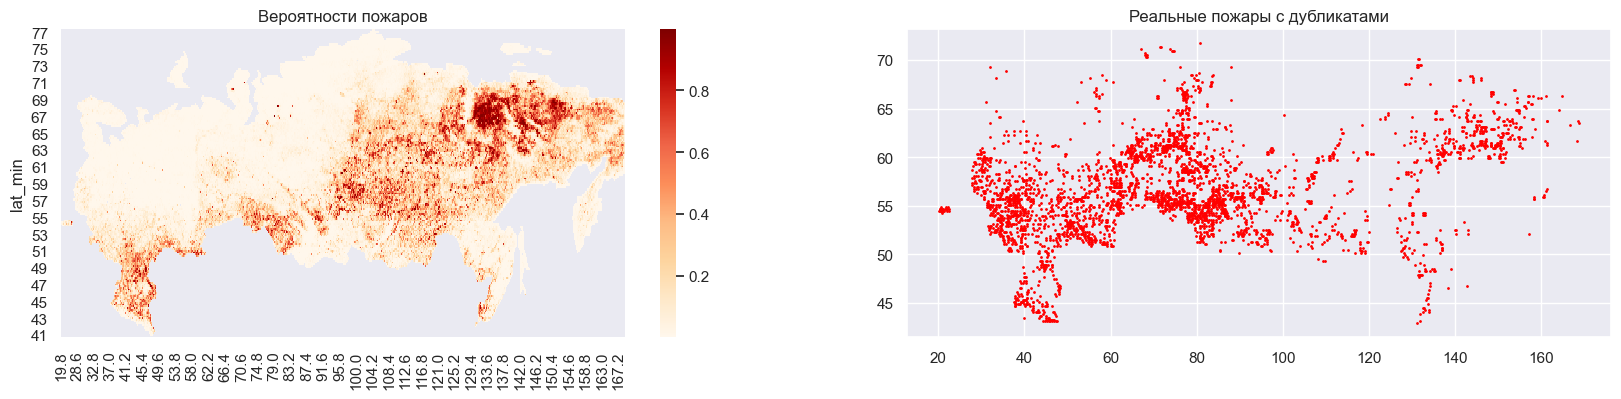

In [158]:
sns.set(rc={"figure.figsize":(20, 4)})

plt.subplot(1, 2, 1)
pic = sns.heatmap(heatmap_data, cmap='OrRd', zorder=1)
pic.invert_yaxis()
plt.title('Вероятности пожаров')

plt.subplot(1, 2, 2)
plt.scatter(
    res_df_no_dup['longitude'], 
    res_df_no_dup['latitude'],
    c="red", 
    s=1,
    zorder=2
)
plt.title('Реальные пожары с дубликатами')

plt.show()

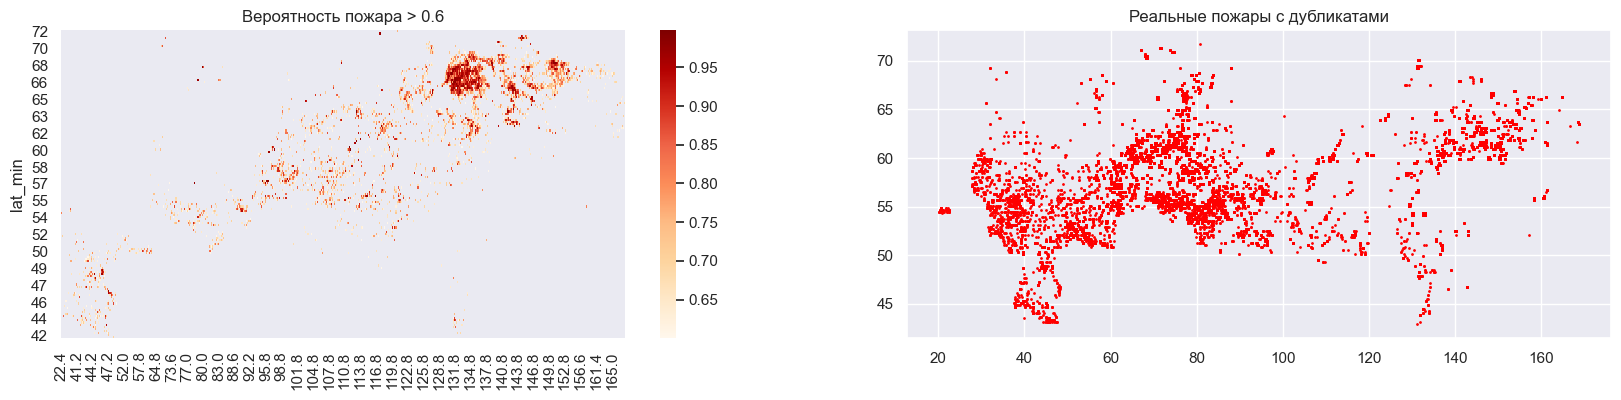

In [159]:
threshold = 0.6

df08 = df_pred[(df_pred['fire_proba'] >= threshold)]
heatmap_data_threshold = df08.pivot(index='lat_min', columns='lon_min', values='fire_proba')
heatmap_data_threshold.index = heatmap_data_threshold.index.astype(int)
heatmap_data_threshold.columns = [round(col, 1) for col in heatmap_data_threshold.columns]

sns.set(rc={"figure.figsize":(20, 4)})
plt.subplot(1, 2, 1)
pic = sns.heatmap(heatmap_data_threshold, cmap='OrRd', zorder=1)
pic.invert_yaxis()
plt.title(f'Вероятность пожара > {value}')
plt.subplot(1, 2, 2)
plt.scatter(
    res_df['longitude'], 
    res_df['latitude'],
    c="red",
    s=1,
    zorder=2
)
plt.title('Реальные пожары с дубликатами')
plt.show()

### Зависят ли предсказания от площади пожара на ячейке?
Гипотеза - чем больше больше вероятность, тем больше точек пожара на ячейке

In [160]:
df_group_by_counts = res_df.groupby(['lon_min', 'lat_min', 'fire_proba']).size().reset_index(name='counts')
df_group_by_counts = df_group_by_counts.sort_values(['counts'])
df_group_by_counts

,lon_min,lat_min,fire_proba,counts
2689,96.2,52.0,0.013846,1
2876,113.6,51.6,0.141311,1
813,47.8,54.8,0.153362,1
812,47.8,54.0,0.206328,1
811,47.8,52.0,0.167246,1
...,...,...,...,...
3301,149.4,61.2,0.137469,708
2430,86.0,54.2,0.336646,1003
1897,77.0,58.8,0.024560,1040
3274,148.0,59.8,0.145848,1071


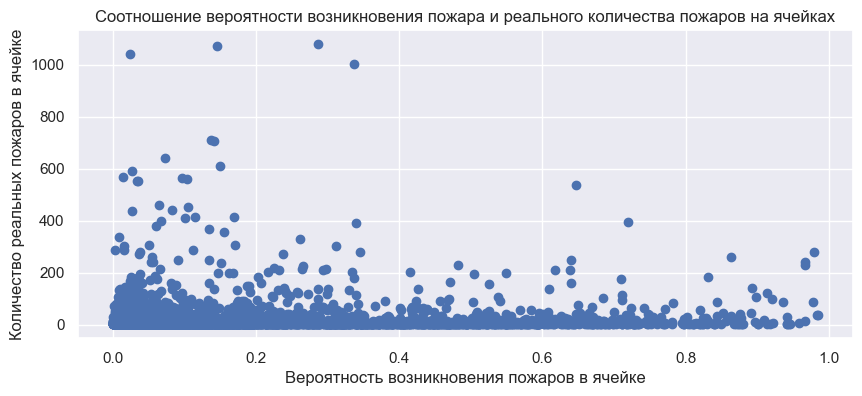

In [161]:
plt.figure(figsize=(10,4))
plt.scatter(df_group_by_counts['fire_proba'], df_group_by_counts['counts'])
plt.xlabel("Вероятность возникновения пожаров в ячейке")
plt.ylabel("Количество реальных пожаров в ячейке")
plt.title("Соотношение вероятности возникновения пожара и реального количества пожаров на ячейках")
plt.show()

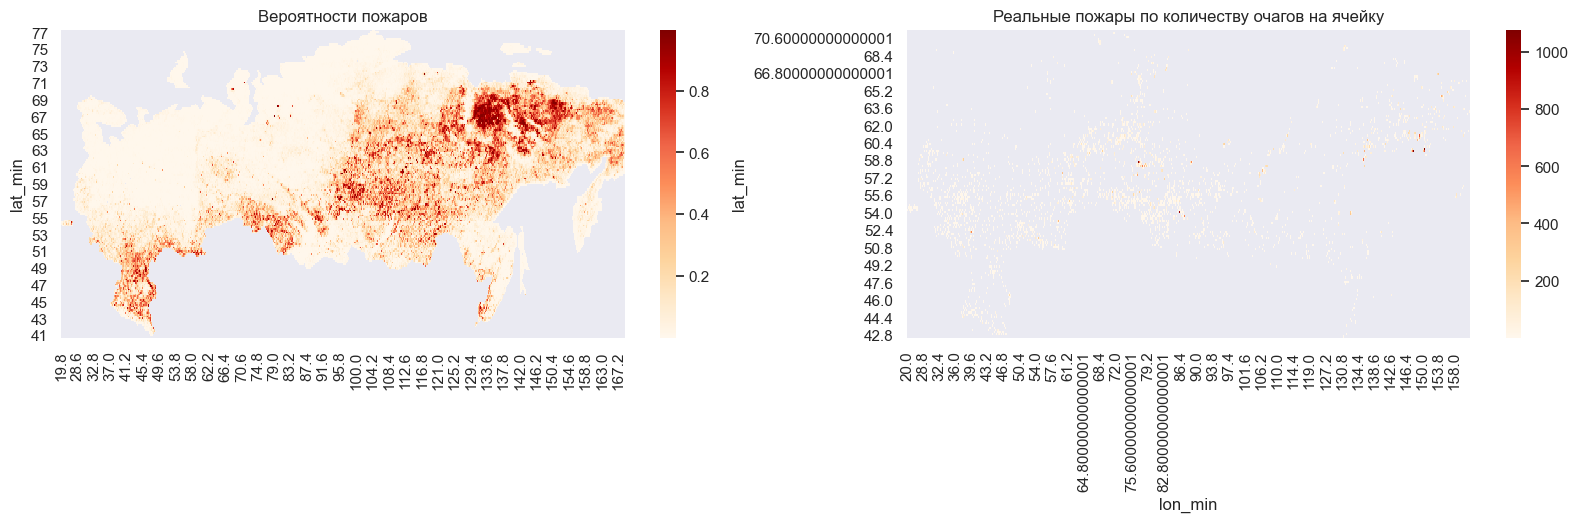

In [162]:
heatmap_data_counts = df_group_by_counts.pivot(index='lat_min', columns='lon_min', values='counts')

sns.set(rc={"figure.figsize":(20, 4)})
plt.subplot(1, 2, 1)
pic = sns.heatmap(heatmap_data, cmap='OrRd', zorder=1)
pic.invert_yaxis()
plt.title('Вероятности пожаров')

plt.subplot(1, 2, 2)
fig = sns.heatmap(heatmap_data_counts, cmap='OrRd', zorder=1)
fig.invert_yaxis()
plt.title('Реальные пожары по количеству очагов на ячейку')

plt.show()

In [163]:
df_group_by_counts[['fire_proba', 'counts']].corr()

,fire_proba,counts
fire_proba,1.000000,0.010248
counts,0.010248,1.000000


**Вывод:** зависимости между вероятностью пожара и количеством реальных пожаров нет

### Зависят ли предсказания от мощности пожара?
Гипотеза - чем больше больше вероятность, тем мощнее (ярче) пожар - параметр brightness в датасете с реальными пожарами

In [164]:
res_df_bri = res_df.sort_values(['brightness'], ascending=False)
res_df_bri

,longitude,latitude,fire_proba,lon_min,lat_min,lon_max,lat_max,real_longitude,real_latitude,brightness
30609,132.9,54.3,0.050395,132.8,54.2,133.0,54.4,132.89606,54.22505,367.00
32203,53.9,51.9,0.033030,53.8,51.8,54.0,52.0,53.81618,51.84340,367.00
23005,80.7,51.7,0.168626,80.6,51.6,80.8,51.8,80.64661,51.65789,367.00
23007,80.7,51.7,0.168626,80.6,51.6,80.8,51.8,80.68059,51.67677,367.00
23008,80.7,51.7,0.168626,80.6,51.6,80.8,51.8,80.67411,51.67451,367.00
...,...,...,...,...,...,...,...,...,...,...
31852,80.3,58.7,0.024486,80.2,58.6,80.4,58.8,80.21618,58.73650,207.93
56539,136.1,58.5,0.134847,136.0,58.4,136.2,58.6,136.10551,58.45020,207.93
31623,78.3,58.5,0.027373,78.2,58.4,78.4,58.6,78.29366,58.54292,207.93
31966,76.7,57.7,0.064042,76.6,57.6,76.8,57.8,76.75296,57.79736,207.93


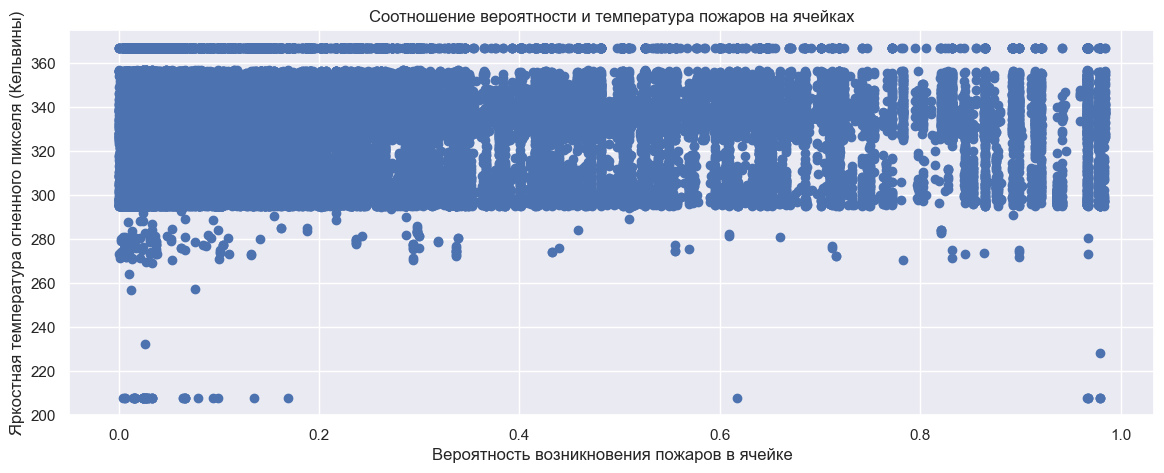

In [165]:
plt.figure(figsize=(14,5))
plt.scatter(res_df_bri['fire_proba'], res_df_bri['brightness'])
plt.xlabel("Вероятность возникновения пожаров в ячейке")
plt.ylabel("Яркостная температура огненного пикселя (Кельвины)")
plt.title("Соотношение вероятности и температура пожаров на ячейках")
plt.show()

In [166]:
res_df_bri[['fire_proba', 'brightness']].corr()

,fire_proba,brightness
fire_proba,1.000000,0.043615
brightness,0.043615,1.000000


**Вывод:** зависимости между вероятностью пожара и яркостью нет

## Рассмотрим предсказания на 18 недель

27 мая - 30 сентября

In [167]:
df_pred_18 = read_pred(df_pred_18)
df_pred_18.head()

,longitude,latitude,fire_proba,lon_min,lat_min,lon_max,lat_max
0,19.9,54.5,0.144576,19.8,54.4,20.0,54.6
1,19.9,54.7,0.011469,19.8,54.6,20.0,54.8
2,20.1,54.3,0.006320,20.0,54.2,20.2,54.4
3,20.1,54.5,0.328001,20.0,54.4,20.2,54.6
4,20.1,54.7,0.015063,20.0,54.6,20.2,54.8


In [168]:
df_real_data_18 = df_real.copy()
df_real_data_18[['year', 'month', 'day']] = df_real_data_18['acq_date'].str.split('-', expand= True).astype(int)
df_real_data_18.drop(['acq_date'], axis= 1, inplace= True)
df_real_data_18 = df_real_data_18[
            (df_real_data_18['month'] == 5) & (df_real_data_18['day'] >= 27) |
            (df_real_data_18['month'] == 6) | (df_real_data_18['month'] == 7) |
            (df_real_data_18['month'] == 8) | (df_real_data_18['month'] == 9)
].reset_index(drop=True)

print('Количество центров случившихся пожаров:', len(df_real_data_18))

Количество центров случившихся пожаров: 576267


In [208]:
# res = {}
# for i, row in df_real_data_18.iterrows():
#     a = df_pred_18[(df_pred_18.lon_min <= row['longitude']) & (df_pred_18.lon_max >= row['longitude']) &
#     (df_pred_18.lat_min <= row['latitude']) & (df_pred_18.lat_max >= row['latitude'])].values.tolist()
#     if len(a) > 0:
#         a = a[0]
#         a.append(row['longitude'])
#         a.append(row['latitude'])
#         a.append(row['brightness'])
#         res[i] = a
# res_df_18 = pd.DataFrame.from_dict(res, orient='index', 
#                 columns=['longitude', 'latitude', 'fire_proba', 'lon_min', 'lat_min', 'lon_max','lat_max', 'real_longitude', 'real_latitude', 'brightness'])
# res_df_18.to_csv(f'../res/NEW_result18_brightness.csv', index = False)

res_df_18 = pd.read_csv('../res/NEW_result18_brightness.csv')

res_df_18

,longitude,latitude,fire_proba,lon_min,lat_min,lon_max,lat_max,real_longitude,real_latitude,brightness
0,39.5,52.5,0.199468,39.4,52.4,39.6,52.6,39.57774,52.55636,322.87
1,37.9,51.1,0.231377,37.8,51.0,38.0,51.2,37.93134,51.13934,332.26
2,37.9,51.1,0.231377,37.8,51.0,38.0,51.2,37.99788,51.12098,298.34
3,36.7,50.7,0.793106,36.6,50.6,36.8,50.8,36.60144,50.61432,301.58
4,36.5,50.7,0.190764,36.4,50.6,36.6,50.8,36.55828,50.61169,304.90
...,...,...,...,...,...,...,...,...,...,...
571937,120.7,55.7,0.090554,120.6,55.6,120.8,55.8,120.61174,55.74533,299.51
571938,120.7,55.7,0.090554,120.6,55.6,120.8,55.8,120.61829,55.72254,300.37
571939,120.7,55.7,0.090554,120.6,55.6,120.8,55.8,120.61688,55.71903,308.06
571940,106.7,56.5,0.385449,106.6,56.4,106.8,56.6,106.79935,56.45775,308.41


### Отличается ли картинка предсказаний на разных сроках?

In [170]:
heatmap_data_18 = df_pred_18.pivot(index='lat_min', columns='lon_min', values='fire_proba')
heatmap_data_18.index = heatmap_data_18.index.astype(int)
heatmap_data_18.columns = [round(col, 1) for col in heatmap_data_18.columns]

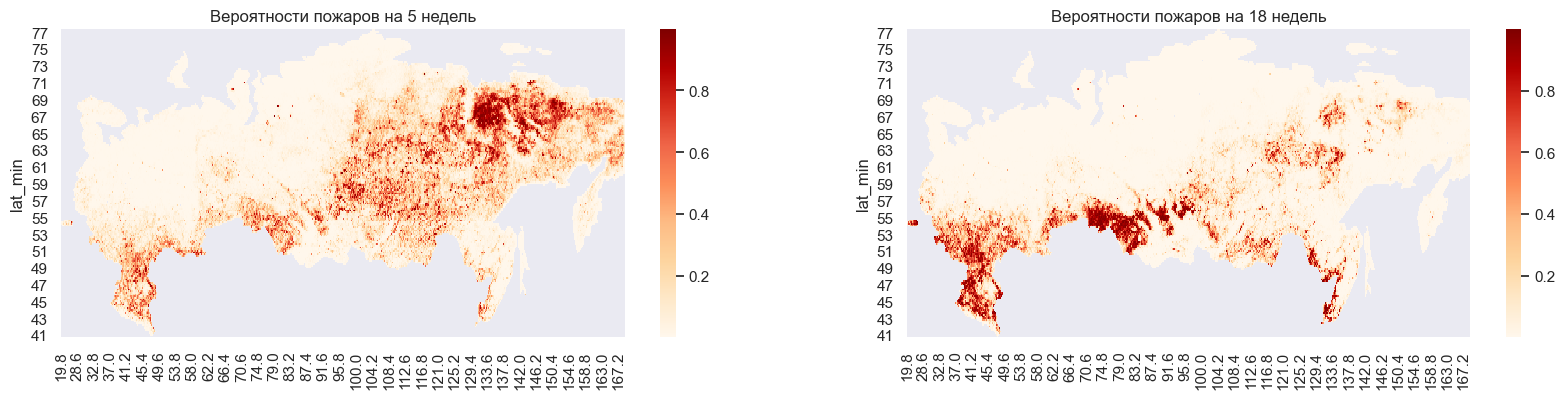

In [171]:
sns.set(rc={"figure.figsize":(20, 4)})
plt.subplot(1, 2, 2)
pic = sns.heatmap(heatmap_data_18, cmap='OrRd', zorder=1)
pic.invert_yaxis()
plt.title('Вероятности пожаров на 18 недель')

plt.subplot(1, 2, 1)
pic = sns.heatmap(heatmap_data, cmap='OrRd', zorder=1)
pic.invert_yaxis()
plt.title('Вероятности пожаров на 5 недель')
plt.show()

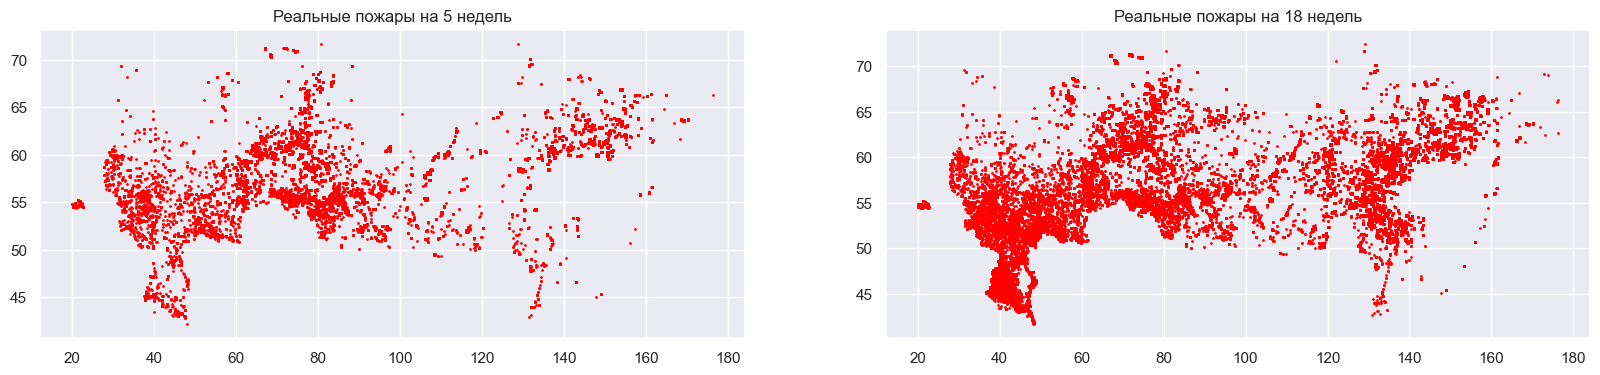

In [172]:
sns.set(rc={"figure.figsize":(20, 4)})

plt.subplot(1, 2, 1)
plt.scatter(
    df_real_data['longitude'], 
    df_real_data['latitude'],
    c="red",
    s=1,
    zorder=2
)
plt.title('Реальные пожары на 5 недель')

plt.subplot(1, 2, 2)
plt.scatter(
    df_real_data_18['longitude'], 
    df_real_data_18['latitude'],
    c="red",
    s=1,
    zorder=2
)
plt.title('Реальные пожары на 18 недель')
plt.show()

### Распределение вероятностей по совпадениям на 18 недель

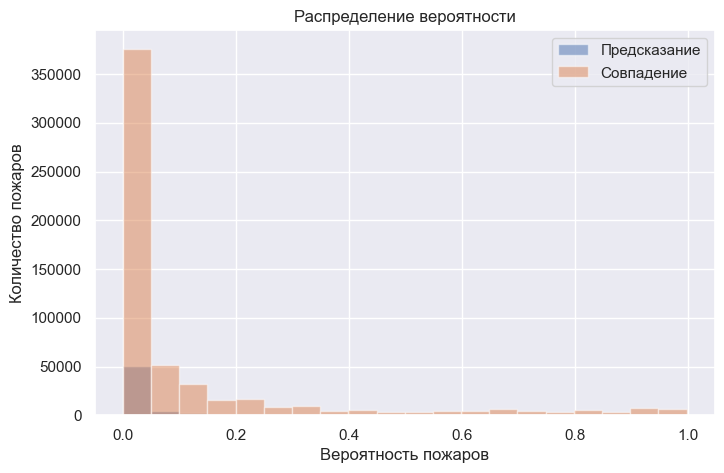

In [173]:
plt.figure(figsize=(8,5))
df_pred_18['fire_proba'].plot(
    kind='hist',
    title='Распределение вероятности',
    alpha=0.5,
    label='Предсказание',
    bins = 20
)
res_df_18['fire_proba'].plot(
    kind='hist',
    alpha=0.5,
    label = 'Совпадение',
    bins = 20
)
plt.xlabel('Вероятность пожаров')
plt.ylabel('Количество пожаров')
plt.legend()
plt.show()

Количество совпадений: 571942
Количество совпадений без дубликатов: 8402


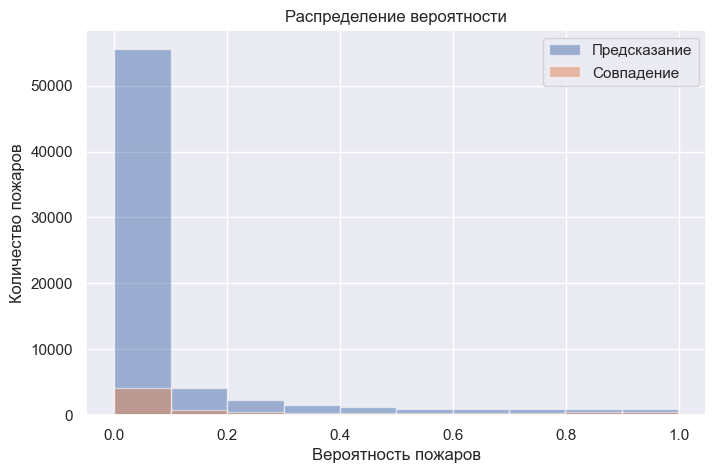

In [174]:
# удаляем дубликаты из пересечений, тк в одном квадрате мб несколько очагов
res_df_18_no_dup = res_df_18.copy()
res_df_18_no_dup = res_df_18_no_dup.drop_duplicates(subset=['latitude', 'longitude'])
print('Количество совпадений:', len(res_df_18))
print('Количество совпадений без дубликатов:', len(res_df_18_no_dup))

plt.figure(figsize=(8,5))
df_pred_18['fire_proba'].plot(
    kind='hist',
    title='Распределение вероятности',
    alpha=0.5,
    label='Предсказание',
    bins=10
)
res_df_18_no_dup['fire_proba'].plot(
    kind='hist',
    alpha=0.5,
    label='Совпадение',
    bins=10
)
plt.xlabel('Вероятность пожаров')
plt.ylabel('Количество пожаров')
plt.legend()
plt.show()

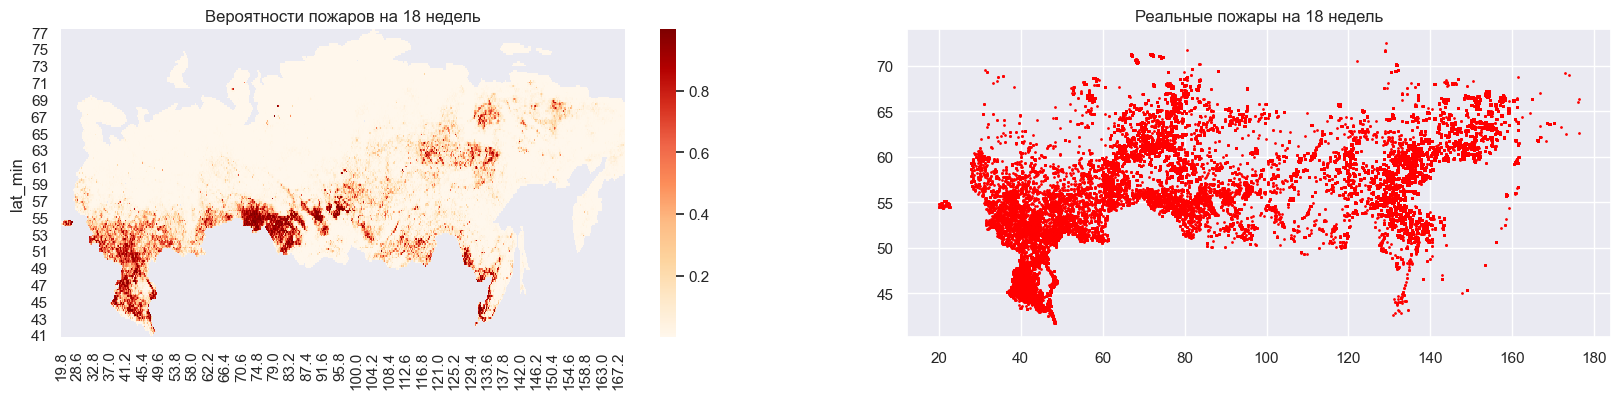

In [175]:
sns.set(rc={"figure.figsize":(20, 4)})

plt.subplot(1, 2, 1)
pic = sns.heatmap(heatmap_data_18, cmap='OrRd', zorder=1)
pic.invert_yaxis()
plt.title('Вероятности пожаров на 18 недель')

plt.subplot(1, 2, 2)
plt.scatter(
    df_real_data_18['longitude'], 
    df_real_data_18['latitude'],
    c="red",
    s=1,
    zorder=2
)
plt.title('Реальные пожары на 18 недель')
plt.show()

### Зависят ли предсказания от площади пожара на ячейке?
Гипотеза - чем больше больше вероятность, тем больше точек пожара на ячейке

In [176]:
df_group_by_counts_18 = res_df_18.groupby(['lon_min', 'lat_min', 'fire_proba']).size().reset_index(name='counts')
df_group_by_counts_18 = df_group_by_counts_18.sort_values(['counts'])
df_group_by_counts_18

,lon_min,lat_min,fire_proba,counts
5188,82.8,58.2,0.403778,1
1822,43.4,59.0,0.003957,1
4570,76.4,56.2,0.598676,1
1824,43.4,60.4,0.006743,1
5306,84.4,66.2,0.000686,1
...,...,...,...,...
7342,134.6,61.0,0.108464,3201
7478,136.0,59.6,0.003853,3246
6715,127.8,55.2,0.103821,3667
7361,134.8,61.0,0.231434,3707


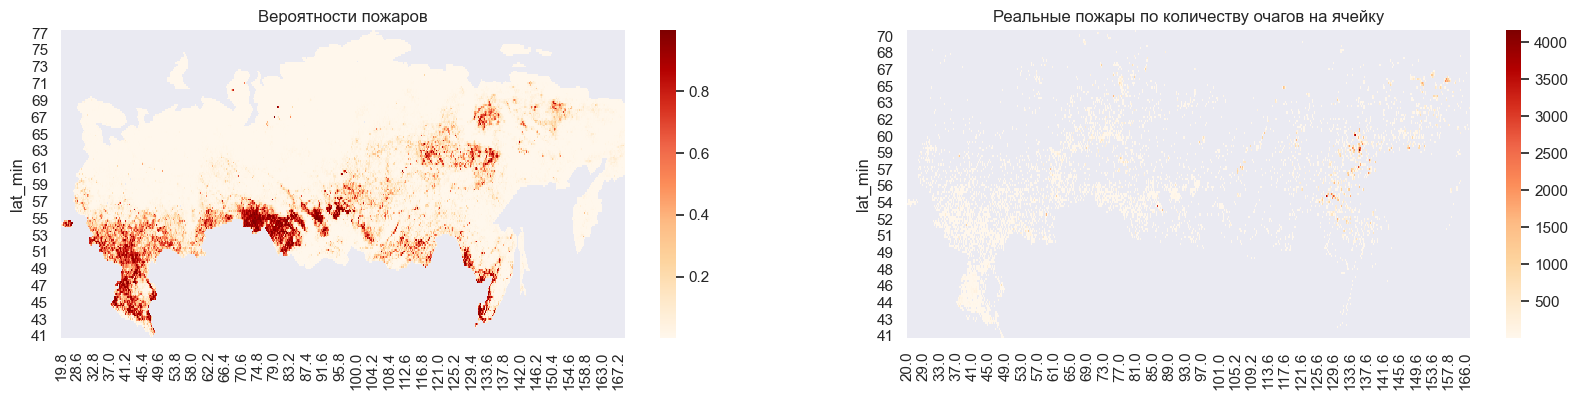

In [177]:
heatmap_data_counts_18 = df_group_by_counts_18.pivot(index='lat_min', columns='lon_min', values='counts')
heatmap_data_counts_18.index = heatmap_data_counts_18.index.astype(int)
heatmap_data_counts_18.columns = [round(col, 1) for col in heatmap_data_counts_18.columns]
sns.set(rc={"figure.figsize":(20, 4)})

plt.subplot(1, 2, 1)
pic = sns.heatmap(heatmap_data_18, cmap='OrRd', zorder=1)
pic.invert_yaxis()
plt.title('Вероятности пожаров')

plt.subplot(1, 2, 2)
fig = sns.heatmap(heatmap_data_counts_18, cmap='OrRd', zorder=1)
fig.invert_yaxis()
plt.title('Реальные пожары по количеству очагов на ячейку')

plt.show()

## Метрики

#### Рассмотрим метрики для разных порогов вероятности для 5 недель

In [209]:
#создадим столбец, отражающий информацию, был ли пожар в ячейке

# df_prob = df_pred.copy()
# df_prob = df_prob.drop(["longitude", "latitude"], axis = 1)
# df_prob['fire_occurred'] = 0

# for i, row in df_pred.iterrows():
#     a = df_real_data[(row['lon_min'] <= df_real_data.longitude) & (row['lon_max'] >= df_real_data.longitude) &
#     (row['lat_min'] <= df_real_data.latitude) & (row['lat_max'] >= df_real_data.latitude)].values.tolist()
#     if len(a) > 0:
#         df_prob.at[i, 'fire_occurred'] = 1       
# df_prob.to_csv(f'../res/result1_tf.csv', index = False)

df_prob = pd.read_csv('../res/result1_tf.csv')
df_prob.head(2)

,longitude,latitude,fire_proba,lon_min,lat_min,lon_max,lat_max,fire_occurred
0,19.9,54.5,0.021414,19.8,54.4,20.0,54.6,0
1,19.9,54.7,0.004216,19.8,54.6,20.0,54.8,0


In [179]:
pred = df_prob['fire_proba'].values
y = df_prob['fire_occurred'].values

In [180]:
confusion_matrixes = {}
for threshold in np.arange(0, 1, 0.01):
    tn, fp, fn, tp = metrics.confusion_matrix(y, (pred > threshold).astype(np.int64)).ravel()
    confusion_matrixes[threshold] = (tn, fp, fn, tp)

In [181]:
metrics_df = pd.DataFrame().from_dict(
    confusion_matrixes, orient='index', 
    columns=['TN', 'FP', 'FN', 'TP']
)
metrics_df['Precision'] = metrics_df['TP'] / (metrics_df['TP'] + metrics_df['FP'])
metrics_df['Recall'] = metrics_df['TP'] / (metrics_df['TP'] + metrics_df['FN'])
metrics_df['Accuracy'] = (
    (metrics_df['TP'] + metrics_df['TN']) / 
    (metrics_df['TP'] + metrics_df['TN'] + metrics_df['FP'] + metrics_df['FN'])
) * 100
metrics_df['F1'] = (
    2 * metrics_df['Precision'] * metrics_df['Recall'] / 
    (metrics_df['Precision'] + metrics_df['Recall'])
)

metrics_df

,TN,FP,FN,TP,Precision,Recall,Accuracy,F1
0.00,0,66172,0,3428,0.049253,1.000000,4.925287,0.093882
0.01,18719,47453,402,3026,0.059946,0.882730,31.242816,0.112267
0.02,25106,41066,692,2736,0.062463,0.798133,40.002874,0.115859
0.03,28878,37294,912,2516,0.063200,0.733956,45.106322,0.116379
0.04,31614,34558,1095,2333,0.063240,0.680572,48.774425,0.115727
...,...,...,...,...,...,...,...,...
0.95,66018,154,3420,8,0.049383,0.002334,94.864943,0.004457
0.96,66067,105,3421,7,0.062500,0.002042,94.933908,0.003955
0.97,66118,54,3424,4,0.068966,0.001167,95.002874,0.002295
0.98,66155,17,3426,2,0.105263,0.000583,95.053161,0.001160


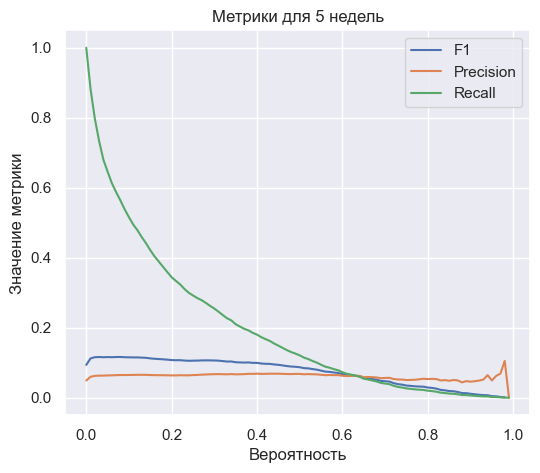

In [182]:
plt.figure(figsize=[6, 5])
metrics_df["F1"].plot()
metrics_df["Precision"].plot()
metrics_df["Recall"].plot()
plt.title('Метрики для 5 недель')
plt.xlabel('Вероятность')
plt.ylabel('Значение метрики')
plt.legend();

In [183]:
metrics_df[
    metrics_df.F1 == metrics_df.F1.max()
]

,TN,FP,FN,TP,Precision,Recall,Accuracy,F1
0.08,38350,27822,1496,1932,0.064932,0.563594,57.876437,0.116449


In [184]:
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)

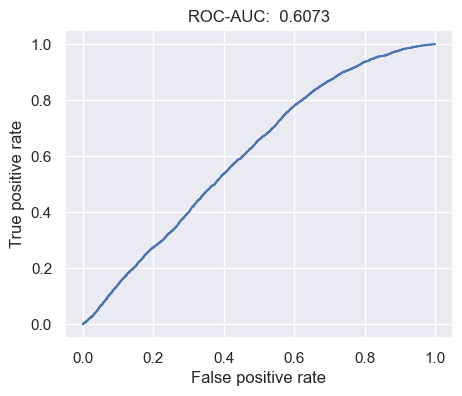

In [185]:
plt.figure(figsize=[5,4])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f'ROC-AUC: {roc_auc: .4f}')
plt.plot(fpr, tpr)
plt.show()

#### Рассмотрим метрики для разных порогов вероятности для 18 недель

In [210]:
# # создадим столбец, отражающий информацию, был ли пожар в ячейке
# df_prob_18 = df_pred_18.copy()
# df_prob_18 = df_prob_18.drop(["longitude", "latitude"], axis = 1)
# df_prob_18['fire_occurred'] = 0

# for i, row in df_pred_18.iterrows():
#     a = df_real_data_18[(row['lon_min'] <= df_real_data_18.longitude) & (row['lon_max'] >= df_real_data_18.longitude) &
#     (row['lat_min'] <= df_real_data_18.latitude) & (row['lat_max'] >= df_real_data_18.latitude)].values.tolist()
#     if len(a) > 0:
#         df_prob_18.at[i, 'fire_occurred'] = 1       
# df_prob_18
# df_prob_18.to_csv(f'../res/result1_tf18.csv', index = False)

df_prob_18 = pd.read_csv('../res/result1_tf18.csv')
df_prob_18.head(2)

,fire_proba,lon_min,lat_min,lon_max,lat_max,fire_occurred
0,0.144576,19.8,54.4,20.0,54.6,0
1,0.011469,19.8,54.6,20.0,54.8,0


In [190]:
pred_18 = df_prob_18['fire_proba'].values
y_18 = df_prob_18['fire_occurred'].values

In [191]:
confusion_matrixes_18 = {}
for threshold in np.arange(0, 1, 0.01):
    tn, fp, fn, tp = metrics.confusion_matrix(y_18, (pred_18 > threshold).astype(np.int64)).ravel()
    confusion_matrixes_18[threshold] = (tn, fp, fn, tp)

In [192]:
metrics_df18 = pd.DataFrame().from_dict(
    confusion_matrixes_18, orient='index', 
    columns=['TN', 'FP', 'FN', 'TP']
    )
metrics_df18['Precision'] = metrics_df18['TP'] / (metrics_df18['TP'] + metrics_df18['FP'])
metrics_df18['Recall'] = metrics_df18['TP'] / (metrics_df18['TP'] + metrics_df18['FN'])
metrics_df18['Accuracy'] = (
    (metrics_df18['TP'] + metrics_df18['TN']) / 
    (metrics_df18['TP'] + metrics_df18['TN'] + metrics_df18['FP'] + metrics_df18['FN'])
    ) * 100
metrics_df18['F1'] = (
    2 * metrics_df18['Precision'] * metrics_df18['Recall'] / 
    (metrics_df18['Precision'] + metrics_df18['Recall'])
    )

metrics_df

,TN,FP,FN,TP,Precision,Recall,Accuracy,F1
0.00,0,66172,0,3428,0.049253,1.000000,4.925287,0.093882
0.01,18719,47453,402,3026,0.059946,0.882730,31.242816,0.112267
0.02,25106,41066,692,2736,0.062463,0.798133,40.002874,0.115859
0.03,28878,37294,912,2516,0.063200,0.733956,45.106322,0.116379
0.04,31614,34558,1095,2333,0.063240,0.680572,48.774425,0.115727
...,...,...,...,...,...,...,...,...
0.95,66018,154,3420,8,0.049383,0.002334,94.864943,0.004457
0.96,66067,105,3421,7,0.062500,0.002042,94.933908,0.003955
0.97,66118,54,3424,4,0.068966,0.001167,95.002874,0.002295
0.98,66155,17,3426,2,0.105263,0.000583,95.053161,0.001160


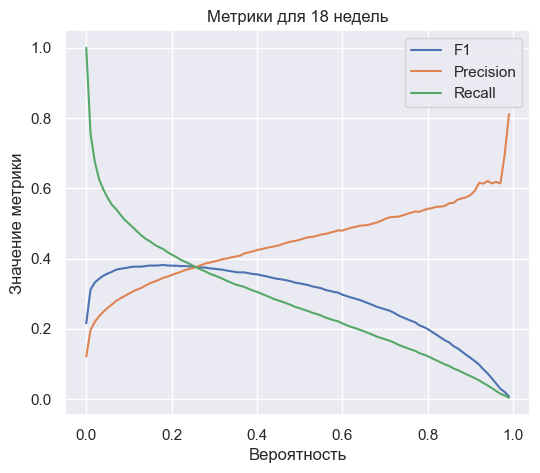

In [193]:
plt.figure(figsize=[6, 5])
metrics_df18["F1"].plot()
metrics_df18["Precision"].plot()
metrics_df18["Recall"].plot()
plt.title('Метрики для 18 недель')
plt.xlabel('Вероятность')
plt.ylabel('Значение метрики')
plt.legend();

In [194]:
metrics_df18[
    metrics_df18.F1 == metrics_df18.F1.max()
]

,TN,FP,FN,TP,Precision,Recall,Accuracy,F1
0.18,54385,6812,4815,3588,0.345,0.42699,83.29454,0.381641


In [195]:
fpr_18, tpr_18, thresholds_18 = metrics.roc_curve(y_18, pred_18)
roc_auc_18 = metrics.auc(fpr_18, tpr_18)

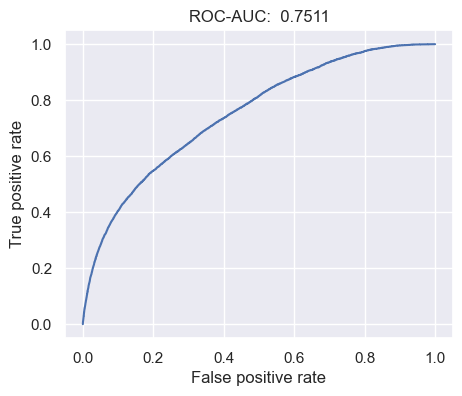

In [196]:
plt.figure(figsize=[5,4])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f'ROC-AUC: {roc_auc_18: .4f}')
plt.plot(fpr_18, tpr_18)
plt.show()